In [101]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_curve, auc, mean_squared_error

In [2]:
df = pd.read_csv("transactions_full_2.csv")
df = df.drop('Unnamed: 0', axis=1)
df.IS_FRAUDSTER = df.IS_FRAUDSTER.fillna(False).astype('int')
df.head()

,CURRENCY,AMOUNT,TRAN_STATE,TRAN_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,CODE,NAME,CODE3,NUMCODE,PHONECODE,IS_FRAUDSTER_N
0,GBP,175,COMPLETED,46:20.3,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,GB,1962.0,PASSED,0.0,GB,United Kingdom,gBR,826.0,44.0,0
1,EUR,2593,COMPLETED,38:47.2,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,...,IE,1995.0,PASSED,0.0,IE,Ireland,iRL,372.0,353.0,0
2,EUR,1077,COMPLETED,34:39.7,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,...,CZ,1985.0,PASSED,0.0,CZ,Czech Republic,CZE,203.0,420.0,0
3,GBP,198,COMPLETED,45:50.6,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,...,GB,1974.0,PASSED,0.0,GB,United Kingdom,gBR,826.0,44.0,0
4,EUR,990,COMPLETED,45:32.7,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,...,FR,1991.0,PASSED,0.0,FR,France,FRA,250.0,33.0,0


In [5]:
df.IS_FRAUDSTER.value_counts()

0    56392
1     1356
Name: IS_FRAUDSTER, dtype: int64

In [8]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [9]:
final_iv, IV = data_vars(df,df.IS_FRAUDSTER)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


In [10]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,CURRENCY,AED,AED,45,0.0,0.000000,45.0,1.000000,0.000000,0.000798,0.000000,0.738204
1,CURRENCY,AUD,AUD,774,0.0,0.000000,774.0,1.000000,0.000000,0.013725,0.000000,0.738204
2,CURRENCY,BTC,BTC,50,2.0,0.040000,48.0,0.960000,0.001475,0.000851,0.549734,0.738204
3,CURRENCY,CAD,CAD,64,0.0,0.000000,64.0,1.000000,0.000000,0.001135,0.000000,0.738204
4,CURRENCY,CHF,CHF,764,0.0,0.000000,764.0,1.000000,0.000000,0.013548,0.000000,0.738204
5,CURRENCY,CZK,CZK,44,0.0,0.000000,44.0,1.000000,0.000000,0.000780,0.000000,0.738204
6,CURRENCY,DKK,DKK,95,0.0,0.000000,95.0,1.000000,0.000000,0.001685,0.000000,0.738204
7,CURRENCY,ETH,ETH,14,0.0,0.000000,14.0,1.000000,0.000000,0.000248,0.000000,0.738204
8,CURRENCY,EUR,EUR,22086,108.0,0.004890,21978.0,0.995110,0.079646,0.389736,-1.587878,0.738204
9,CURRENCY,GBP,GBP,28506,1137.0,0.039886,27369.0,0.960114,0.838496,0.485335,0.546770,0.738204


In [11]:
IV.sort_values('IV')

,VAR_NAME,IV
0,BIRTH_YEAR,0.118934
10,TRAN_STATE,0.152046
3,ENTRY_METHOD,0.173575
5,MERCHANT_CATEGORY,0.184822
11,TYPE,0.238812
6,MERCHANT_COUNTRY,0.435759
8,SOURCE,0.501448
2,CURRENCY,0.738204
1,COUNTRY,0.805221
7,PHONE_COUNTRY,0.822627


In [3]:
# drop useless valiables and those who highly correlates to each other
df = df.drop(columns={'USER_STATE',
                      'TRAN_ID', 'USER_ID', 'IS_FRAUDSTER_N', 'IS_CRYPTO',
                      'EXPONENT', 'HAS_EMAIL', 'NUMCODE', 'FAILED_SIGN_IN_ATTEMPTS',
                      'AMOUNT_USD', 'AMOUNT', 'PHONECODE',
                     'CCY', 'CODE', 'NAME', 'CODE3',
                     'USER_CREATED_DATE', 'TRAN_CREATED_DATE'})

In [4]:
df.to_csv('normalized_df_v2.csv')

In [5]:
transform_vars_list = df.columns.difference(['IS_FRAUDSTER'])
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [6]:
transform_vars_list

Index(['BIRTH_YEAR', 'COUNTRY', 'CURRENCY', 'ENTRY_METHOD', 'KYC',
       'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'PHONE_COUNTRY', 'SOURCE',
       'TERMS_VERSION', 'TRAN_STATE', 'TYPE'],
      dtype='object')

In [19]:
woe_df = pd.DataFrame()

In [20]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    srt_dict = sorted(transform_dict.items(), key=lambda val:val[1])
    replace_cmd = ''
    replace_cmd1 = ''
    for i in srt_dict:
        value = str(i[0])
        meter = str(i[1])
        replace_cmd = replace_cmd + meter + ' if x <= ' + value + ' else '
        replace_cmd1 = replace_cmd1 + meter + ' if x == "' + value + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            woe_df[var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            print(var)
            woe_df[var] = df[var].apply(lambda x: eval(replace_cmd1))

BIRTH_YEAR
COUNTRY
CURRENCY
ENTRY_METHOD
KYC
MERCHANT_CATEGORY
MERCHANT_COUNTRY
PHONE_COUNTRY
SOURCE
TERMS_VERSION
TRAN_STATE
TYPE


In [73]:
woe_df.head()

,BIRTH_YEAR,COUNTRY,CURRENCY,ENTRY_METHOD,KYC,MERCHANT_CATEGORY,MERCHANT_COUNTRY,PHONE_COUNTRY,SOURCE,TERMS_VERSION,TRAN_STATE,TYPE,IS_FRAUDSTER
0,0,0.436167,0.546770,-0.464664,-0.122173,-1.542277,0.459637,0.585970,-0.232866,-0.661286,-0.201351,-0.361293,0
1,0,0.000000,-1.587878,-0.464664,-0.122173,-1.374362,0.000000,0.000000,-0.232866,0.000000,-0.201351,-0.361293,0
2,0,0.000000,-1.587878,-0.464664,-0.122173,0.000000,0.000000,0.000000,-0.232866,-0.661286,-0.201351,-0.361293,0
3,0,0.436167,0.546770,-0.464664,-0.122173,-0.485668,0.459637,0.585970,-0.232866,0.000000,-0.201351,-0.361293,0
4,0,-4.786401,-1.587878,-0.464664,-0.122173,0.000000,0.000000,-4.889793,-0.232866,-0.661286,-0.201351,-0.361293,0


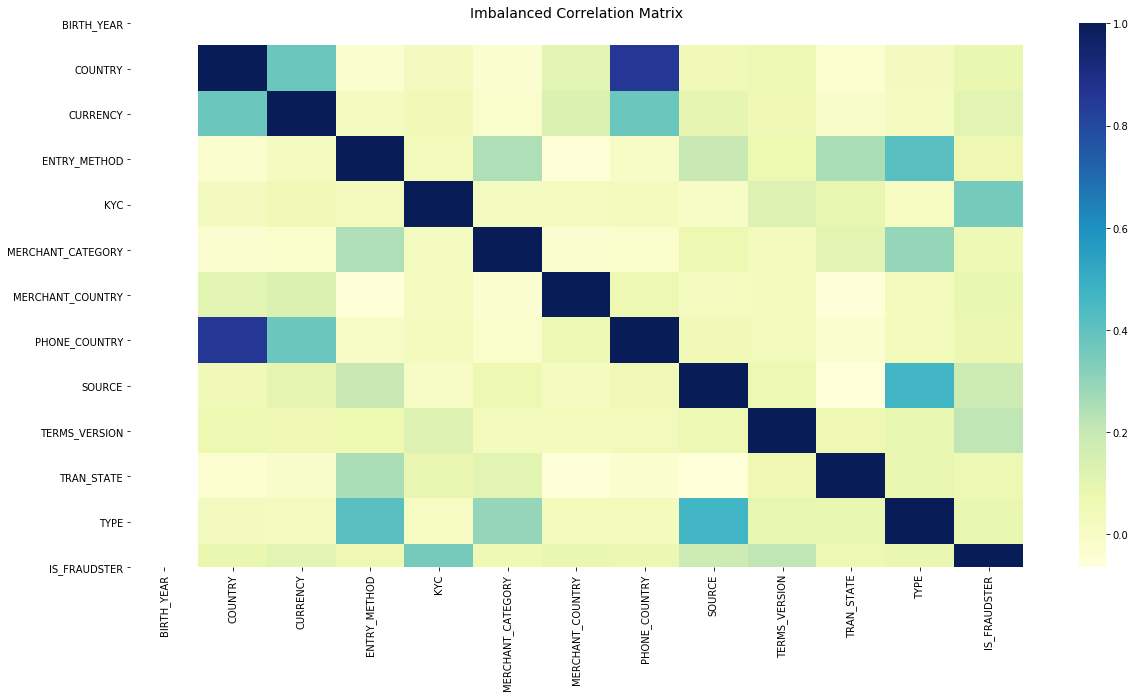

In [22]:
X_tmp = woe_df
X_tmp['IS_FRAUDSTER'] = df.IS_FRAUDSTER
# X_tmp.head()
corr = X_tmp.corr()
# # corr['IS_FRAUDSTER'].sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

In [74]:
X = woe_df.drop(columns={'IS_FRAUDSTER'})
y = df.IS_FRAUDSTER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [75]:
X.columns

Index(['BIRTH_YEAR', 'COUNTRY', 'CURRENCY', 'ENTRY_METHOD', 'KYC',
       'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'PHONE_COUNTRY', 'SOURCE',
       'TERMS_VERSION', 'TRAN_STATE', 'TYPE'],
      dtype='object')

In [76]:
# build logistic regression model
logic_reg_clf = LogisticRegression(random_state=0, solver='lbfgs') \
                    .fit(X_train, y_train)

In [198]:
predictions = logic_reg_clf.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [78]:
precision_score(y_test, predictions)

0.68217054263565891

In [79]:
recall_score(y_test, predictions)

0.1981981981981982

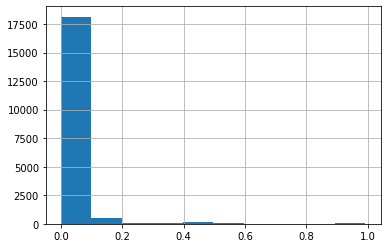

In [222]:
y_predicted_prob = logic_reg_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()
y_pred = np.where(y_predicted_prob[:,1] > 0.15, 1, 0)

In [223]:
np.bincount(y_pred)

array([18518,   539])

In [224]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[18307,   306],
       [  211,   233]])

In [225]:
precision_score(y_test, y_pred)

0.43228200371057512

In [226]:
recall_score(y_test, y_pred)

0.52477477477477474

In [227]:
f1_score(y_test, y_pred)

0.47405900305188198

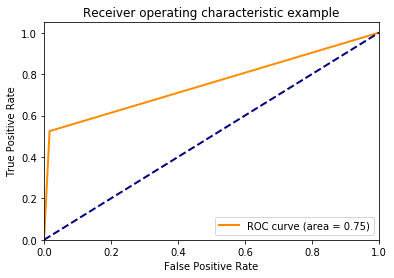

In [228]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [111]:
# build XGBoost model
modelXGB = xgb.XGBRegressor().fit(X_train, y_train)

[12:52:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [112]:
xgbpredictions = modelXGB.predict(X_test)
xgbpredictions

array([-0.00331253,  0.00951064, -0.00316703, ...,  0.00333863,
        0.00162524,  0.00814843], dtype=float32)

In [113]:
mean_squared_error(y_test, xgbpredictions)

0.013205940995355811

In [156]:
xgb_y_pred = np.where(xgbpredictions > 0.1, 1, 0)

In [157]:
precision_score(y_test, xgb_y_pred)

0.33211344922232389

In [158]:
recall_score(y_test, xgb_y_pred)

0.81756756756756754

In [159]:
f1_score(y_test, xgb_y_pred)

0.47234873129472998

In [160]:
confusion_matrix(y_test, xgb_y_pred)

array([[17883,   730],
       [   81,   363]])

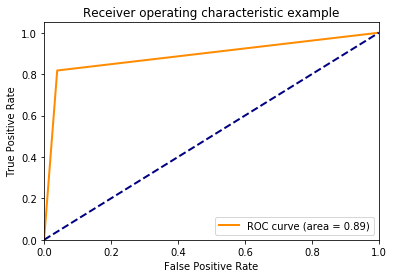

In [197]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [162]:
X_train.shape

(38691, 12)

In [163]:
# build Random Forest model
params = {
    'n_estimators': range(10, 50, 5),
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1,7),
    'max_features': range(1,13)
}
rf = RandomForestClassifier(random_state=0)
search = RandomizedSearchCV(rf, params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops canno

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [164]:
best_rf = search.best_estimator_
fi = best_rf.feature_importances_
fi_df = pd.DataFrame({'features': X.columns, 'feature_importances': fi})
fi_df.sort_values('feature_importances', ascending=False)

,feature_importances,features
4,0.257358,KYC
9,0.152627,TERMS_VERSION
8,0.134169,SOURCE
7,0.118799,PHONE_COUNTRY
1,0.087076,COUNTRY
6,0.083716,MERCHANT_COUNTRY
3,0.039993,ENTRY_METHOD
11,0.034721,TYPE
10,0.034068,TRAN_STATE
5,0.029825,MERCHANT_CATEGORY


In [165]:
predictions = best_rf.predict(X_test)

In [191]:
y_predicted_prob = best_rf.predict_proba(X_test)
y_pred = np.where(y_predicted_prob[:,1] > 0.2, 1, 0)

In [193]:
precision_score(y_test, y_pred)

0.61206896551724133

In [194]:
recall_score(y_test, y_pred)

0.63963963963963966

In [195]:
f1_score(y_test, y_pred)

0.62555066079295163

In [192]:
confusion_matrix(y_test, y_pred)

array([[18433,   180],
       [  160,   284]])

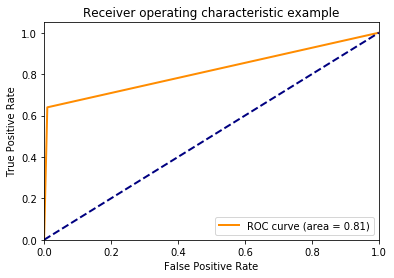

In [196]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()